In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

from models.unet import UNet
from utils.datasets import OrigaDataset, load_origa
from utils.metrics import *

In [22]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
WANDB = False

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cpu


Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5956, 1: 5448, 2: 4980}


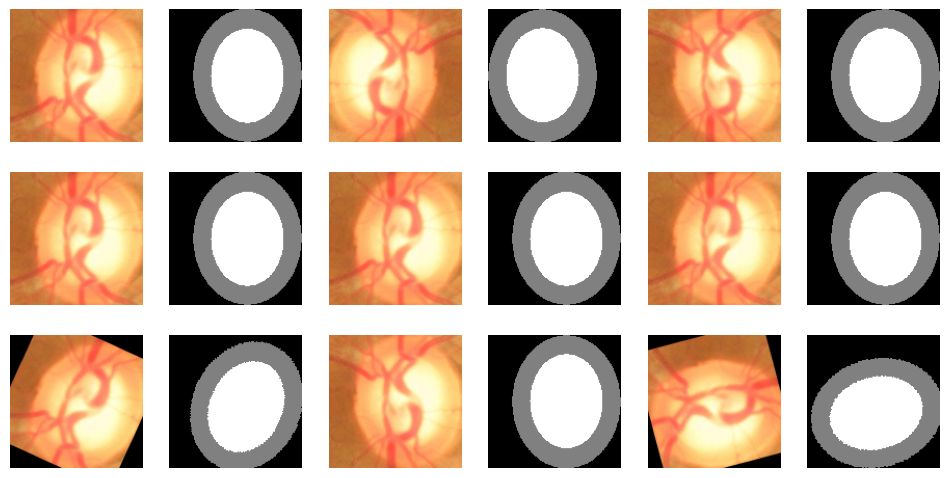

In [23]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    image, mask = next(iter(example_loader))
    image = image.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [24]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    # train_size=0.7, val_size=0.15, test_size=0.15,
    train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train size: 6
Validation size: 7
Test size: 637


In [25]:
def train(model, criterion, optimizer, epochs, device, train_loader, val_loader):
    history = defaultdict(list)

    for epoch in range(epochs):
        train_hist = train_epoch(model, train_loader, criterion, optimizer, device, epoch + 1)
        history['train_loss'].append(train_hist['loss'])
        history['train_accuracy'].append(train_hist['accuracy'])
        history['train_dice'].append(train_hist['dice'])
        history['train_iou'].append(train_hist['iou'])

        val_hist = valid_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_hist['loss'])
        history['val_accuracy'].append(val_hist['accuracy'])
        history['val_dice'].append(val_hist['dice'])
        history['val_iou'].append(val_hist['iou'])

    return history


def train_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    metrics = defaultdict(list)
    n = len(loader)

    loop = tqdm(loader, total=n, leave=True)
    for batch_idx, (images, masks) in enumerate(loop):
        images = images.to(device=device)
        masks = masks.to(device=device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, masks.long())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate metrics
        preds = torch.argmax(outputs, dim=1)
        epoch_metrics = get_performance_metrics(masks, preds)
        for k, v in epoch_metrics.items():
            metrics[k].append(v)
        metrics['loss'].append(loss.item())

        # update tqdm loop
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        loop.set_postfix(loss=loss.item(), accuracy=epoch_metrics['accuracy'],
                         dice=epoch_metrics['dice'], iou=epoch_metrics['iou'])

    # calculate mean metrics
    return {k: np.mean(v) for k, v in metrics.items()}


def valid_epoch(model, loader, criterion, device):
    model.eval()
    metrics = defaultdict(list)
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loader):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # calculate metrics
            preds = torch.argmax(outputs, dim=1)
            epoch_metrics = get_performance_metrics(masks, preds)
            for k, v in epoch_metrics.items():
                metrics[k].append(v)
            metrics['loss'].append(loss.item())

    # mean metrics
    return {k: np.mean(v) for k, v in metrics.items()}


In [26]:
model = UNet(in_channels=3, out_channels=3, features=[64, 128, 256, 512]).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
hist = train(model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader)

Epoch [50/50]: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it, accuracy=0.899, dice=0.902, iou=0.823, loss=0.29]


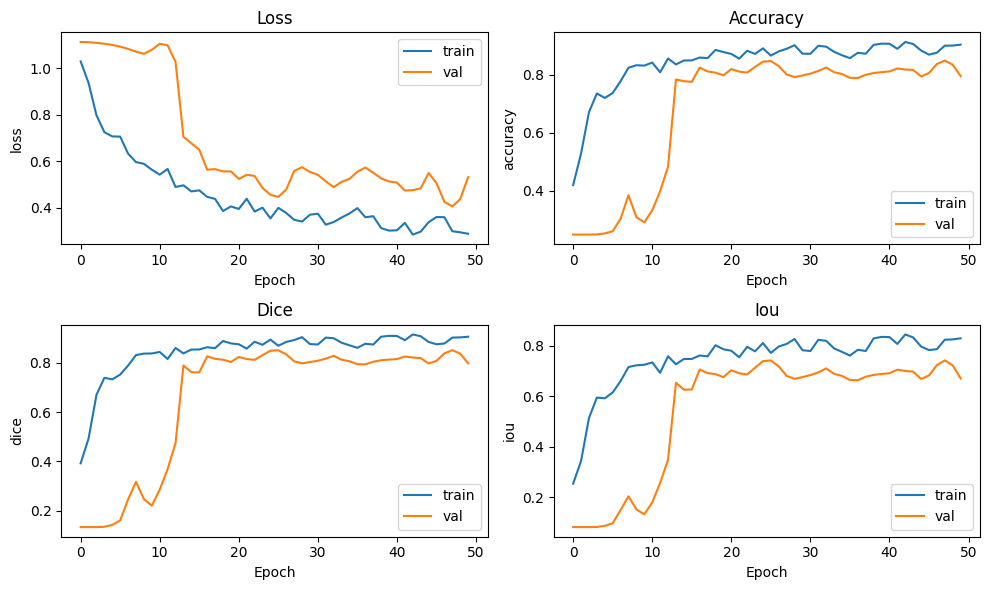

In [29]:
# Plot metrics
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for i, metric in enumerate(['loss', 'accuracy', 'dice', 'iou']):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend()
plt.tight_layout()
plt.show()